In [2]:
%matplotlib inline
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import igraph
import leidenalg

In [34]:
# read in subsetted ann data object
adata = sc.read_h5ad("/w5home/bmoore/scRNAseq/GAMM/GAMM_S2/output_20230830_155530/GAMM_S2_clabeled-clusters_0.5_cones_orthologs.h5ad")
adata


AnnData object with n_obs × n_vars = 516 × 16711
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'CellType_manual'
    var: 'features', 'old_names'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

In [35]:
# get correct gene names based on gene list
def main_gene_selection(X_df, gene_list):
    """
    Describe:
        rebuild the input adata to select target genes encode protein 
    Parameters:
        adata->`~anndata.AnnData` object: adata with var index_name by gene symbol
        gene_list->list: wanted target gene 
    Returns:
        adata_new->`~anndata.AnnData` object
        to_fill_columns->list: zero padding gene
    """
    to_fill_columns = list(set(gene_list) - set(X_df.columns))
    padding_df = pd.DataFrame(np.zeros((X_df.shape[0], len(to_fill_columns))), 
                              columns=to_fill_columns, 
                              index=X_df.index)
    X_df = pd.DataFrame(np.concatenate([df.values for df in [X_df, padding_df]], axis=1), 
                        index=X_df.index, 
                        columns=list(X_df.columns) + list(padding_df.columns))
    X_df = X_df[gene_list]
    
    var = pd.DataFrame(index=X_df.columns)
    var['mask'] = [1 if i in to_fill_columns else 0 for i in list(var.index)]
    return X_df, to_fill_columns,var

gene_list_df = pd.read_csv('/w5home/bmoore/scFoundation_model/model/OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])
X_df= adata.to_df()
X_df, to_fill_columns, var = main_gene_selection(X_df, gene_list)
print(X_df)

                        A1BG      A1CF       A2M     A2ML1   A3GALT2  \
AAACGAAGTTTCGGCG_1 -0.042346 -0.105030 -0.427844 -0.184739 -0.036179   
AAACGAATCGTCTACC_1 -0.043150  6.128100 -0.379275 -0.179870 -0.040108   
AACAAGACAACGATTC_1 -0.037658 -0.103802 -0.357409 -0.204344 -0.052037   
AACAGGGAGTCATAGA_1 -0.044894 -0.102238 -0.508249 -0.175131 -0.022941   
AACCACATCACCCTTG_1 -0.042375 -0.106361 -0.412149 -0.184219 -0.037850   
...                      ...       ...       ...       ...       ...   
TTTACCACACTGTCGG_2 -0.039420 -0.097577 -0.465289 -0.199000 -0.037152   
TTTCATGAGCCAGAGT_2 -0.037614 -0.093242 -0.485196 -0.207719 -0.038104   
TTTGGAGCAGAAGCGT_2 -0.044068 -0.110562 -0.391849 -0.176000 -0.037136   
TTTGGAGCAGGAGACT_2 -0.045522 -0.111476 -0.407204 -0.169757 -0.032928   
TTTGGTTGTCTTCTAT_2 -0.041736 -0.103496 -0.435414 -0.187704 -0.036407   

                      A4GALT     A4GNT      AAAS      AACS     AADAC  ...  \
AAACGAAGTTTCGGCG_1 -0.076534 -0.036593 -0.261514 -0.318321

In [36]:
import skmisc
# turn back to anndata object
#get variable gene_list
adata = sc.AnnData(X_df)
sc.pp.highly_variable_genes(adata) # ,flavor="seurat_v3"

/w5home/bmoore/miniconda3/envs/scfound2/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [6]:
hvg_mask = adata.var['highly_variable'].values
print(hvg_mask)

[False  True False ... False False False]


In [7]:
hvg_indices = np.where(hvg_mask)[0]
print(len(hvg_indices))

3125


In [8]:
# get embedding
cell_geneemb = np.load('/w5home/bmoore/scRNAseq/GAMM/GAMM_S2/Gamm_gene_embed/Gamm_01B-resolution_sc_gene_embedding_a5_cones-orthos.npy')

In [9]:
print(cell_geneemb.shape)

(516, 19264, 512)


In [10]:
# get variable genes and merge with embedding

# Get boolean mask of highly variable genes
# hvg_mask = adata.var['highly_variable']

# # Get indices where genes are highly variable
# hvg_indices = np.where(hvg_mask)[0]

# Now you can use these indices with your gene embeddings
#geneemb_merge = cell_geneemb[:, hvg_indices, :].mean(0)
geneemb_merge = cell_geneemb[:, :, 0]
#geneemb_merge = cell_geneemb[:,selected_gene,:].mean(0)

print(geneemb_merge.shape)


(516, 19264)


In [11]:

# check that anndata and gene embddings line up
anndata_genes = adata.var_names.tolist()
# Check dimensions
print(f"Number of genes in AnnData: {len(anndata_genes)}")
print(f"Number of genes in embeddings: {cell_geneemb.shape[1]}")


Number of genes in AnnData: 19264
Number of genes in embeddings: 19264


In [12]:
# get hvg names
print(len(anndata_genes), len(gene_list))
hvg_genes=np.array(anndata_genes)[hvg_indices]
print(hvg_genes, len(hvg_genes))

19264 19264
['A1CF' 'A2ML1' 'AAAS' ... 'ZSWIM9' 'ZW10' 'ZWILCH'] 3125


In [13]:
# make gene embedding a dataframe
gene_df = pd.DataFrame(geneemb_merge,columns=anndata_genes)
#print(gene_df)
gene_df_hvg =gene_df[hvg_genes]
# subset gene embedding for highly variable ones
df = gene_df_hvg.dropna()
print(df)

         A1CF     A2ML1      AAAS      AARD      AASS    ABCA13     ABCA5  \
1   -0.029065 -0.005372 -0.114743 -0.112098 -0.169690 -0.084562 -0.346212   
2   -0.092340  0.004172 -0.100836 -0.128004 -0.117614 -0.043266 -0.249092   
4   -0.077428 -0.003263 -0.105324 -0.128132 -0.132012 -0.064145 -0.305729   
5   -0.100685  0.000377 -0.083629 -0.096238 -0.146213 -0.038254 -0.323039   
6   -0.079831  0.011001 -0.090202 -0.162864 -0.121616 -0.120161 -0.200099   
..        ...       ...       ...       ...       ...       ...       ...   
509 -0.113288 -0.004302 -0.083514 -0.185191 -0.242597 -0.069888 -0.429932   
510 -0.095878  0.014114 -0.084381 -0.168374 -0.019550 -0.080027 -0.317537   
511 -0.100276  0.015107 -0.084346 -0.148606 -0.159394 -0.107632 -0.367042   
512 -0.108053  0.009195 -0.090761 -0.159595 -0.138632 -0.034819 -0.310519   
514 -0.099909  0.013776  0.010288 -0.203303 -0.152641 -0.040009 -0.364620   

        ABCA9     ABCB8     ABCB9  ...    ZSCAN2   ZSCAN20   ZSCAN25  \
1  

In [14]:
# transpose to get genes as obs to be clustered
gene_df_hvg_t = df.transpose()
# create anndata obj
gene_adata_hvg=sc.AnnData(gene_df_hvg_t)
print(gene_adata_hvg)

AnnData object with n_obs × n_vars = 3125 × 343


/w5home/bmoore/miniconda3/envs/scfound2/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
print(gene_adata_hvg.X.shape)
print(gene_adata_hvg.shape)

(3125, 343)
(3125, 343)


In [16]:
# check gene names
gene_adata_hvg.obs_names

Index(['A1CF', 'A2ML1', 'AAAS', 'AARD', 'AASS', 'ABCA13', 'ABCA5', 'ABCA9',
       'ABCB8', 'ABCB9',
       ...
       'ZSCAN2', 'ZSCAN20', 'ZSCAN25', 'ZSCAN26', 'ZSCAN9', 'ZSWIM7', 'ZSWIM8',
       'ZSWIM9', 'ZW10', 'ZWILCH'],
      dtype='object', length=3125)

In [17]:
# check embedding array
gene_adata_hvg.X

array([[-0.02906548, -0.09234037, -0.07742777, ..., -0.10027619,
        -0.1080528 , -0.0999092 ],
       [-0.00537204,  0.00417174, -0.00326281, ...,  0.01510747,
         0.00919463,  0.01377584],
       [-0.11474253, -0.10083643, -0.10532365, ..., -0.08434556,
        -0.09076057,  0.01028808],
       ...,
       [-0.15041886, -0.11079245, -0.13763575, ..., -0.10512296,
        -0.10431167, -0.11217408],
       [-0.06946907, -0.07221218, -0.07736467, ..., -0.07470612,
        -0.07421009, -0.07637981],
       [-0.01143494, -0.03156363, -0.02121995, ..., -0.03292383,
        -0.03862242, -0.0327557 ]], dtype=float32)

In [18]:
# cluster on embeddings
sc.pp.neighbors(gene_adata_hvg) #use_rep='X'
sc.tl.umap(gene_adata_hvg)
sc.tl.leiden(gene_adata_hvg,resolution=2)

/w5home/bmoore/miniconda3/envs/scfound2/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 343 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/w5home/bmoore/miniconda3/envs/scfound2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_375397/3077276952.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(gene_adata_hvg,resolution=2)


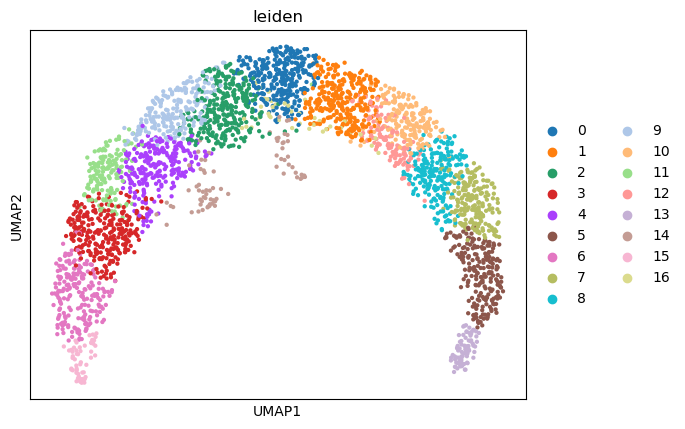

In [19]:
sc.pl.umap(gene_adata_hvg,color='leiden')

In [20]:
# get genes for each cluster
import collections
def get_metagenes(gdata):
    metagenes = collections.defaultdict(list)
    for x, y in zip(gdata.obs["leiden"], gdata.obs.index):
        metagenes[x].append(y)
    return metagenes

metagenes = get_metagenes(gene_adata_hvg)

# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [21]:
print(metagenes.items())


dict_items([('4', ['A1CF', 'ABHD5', 'ACP4', 'ACSL4', 'ADAM23', 'ADAMTS20', 'ADCY6', 'ALDH4A1', 'AMH', 'ANKRD6', 'ANKS6', 'ANOS1', 'ANXA13', 'AP3D1', 'AP5M1', 'ARHGAP22', 'ARHGEF38', 'ASF1A', 'ATG12', 'ATP10D', 'ATP6V1C1', 'BAIAP2L1', 'BCAT2', 'BCDIN3D', 'BEGAIN', 'BET1', 'BMF', 'BMP5', 'BORCS7', 'C2orf72', 'C3orf14', 'CAPN2', 'CAPNS1', 'CASP7', 'CASS4', 'CBARP', 'CD99L2', 'CDC20', 'CDKL3', 'CEP78', 'CFAP44', 'CFAP58', 'CFAP92', 'CFAP97D1', 'CGNL1', 'CHST10', 'CLEC11A', 'CNIH3', 'CNOT8', 'COL13A1', 'COL4A1', 'COLEC11', 'CORIN', 'COX11', 'CRYL1', 'CSMD1', 'CSTF2', 'CUBN', 'DAGLA', 'DCBLD1', 'DCT', 'DDHD2', 'DDR2', 'DLGAP2', 'DLGAP5', 'DTX1', 'DYRK1B', 'DZIP1L', 'ECM2', 'EFHC2', 'EFHD2', 'ELOVL6', 'ELP4', 'EPHA4', 'EYA4', 'FAM171A1', 'FAM178B', 'FAM216A', 'FAM227A', 'FANCD2', 'FBN2', 'FBXO17', 'FHL2', 'FRS3', 'FUT1', 'GAD2', 'GALNT9', 'GALT', 'GBP1', 'GJC1', 'GSDME', 'GTF2H2C', 'HAP1', 'HES2', 'HES5', 'HHIP', 'HMCN1', 'HS3ST5', 'HSD17B3', 'HTR1E', 'IGDCC4', 'IGFBPL1', 'IGFN1', 'IL12RB2', 

In [22]:
import pickle
with open ('mgs.pkl','wb') as f:
    pickle.dump(mgs,f)

In [23]:
len(mgs)

17

In [24]:
# function to score metagenes

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
def score_metagenes(adata, metagenes):
    for p, genes in tqdm(metagenes.items()):
        try:
            sc.tl.score_genes(adata, score_name=str(p) + "_SCORE", gene_list=genes)
            scores = np.array(adata.obs[str(p) + "_SCORE"].tolist()).reshape(-1, 1)
            scaler = MinMaxScaler()
            scores = scaler.fit_transform(scores)
            scores = list(scores.reshape(1, -1))[0]
            adata.obs[str(p) + "_SCORE"] = scores
        except Exception as e:
            adata.obs[str(p) + "_SCORE"] = 0.0

In [25]:
# read back in original data to score on original data
adata = sc.read_h5ad("/w5home/bmoore/scRNAseq/GAMM/GAMM_S2/output_20230830_155530/GAMM_S2_clabeled-clusters_0.5_cones_orthologs.h5ad")
adata

#sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)
# score meta genes on original data
score_metagenes(adata,mgs)

  0%|          | 0/17 [00:00<?, ?it/s]

       'ALDH4A1', 'AMH', 'ANKRD6',
       ...
       'ZBED9', 'ZMAT4', 'ZNF2', 'ZNF366', 'ZNF473', 'ZNF510', 'ZNF582',
       'ZNF615', 'ZNF660', 'ZNF688'],
      dtype='object', length=247)
       'ANAPC4', 'ANGPTL2', 'APEX2',
       ...
       'TUBD1', 'TXNRD3', 'UPP1', 'USP21', 'UTP6', 'VAMP5', 'VAV2', 'VGLL3',
       'YPEL2', 'ZNF26'],
      dtype='object', length=204)
       'ARSK', 'ATG16L2', 'ATIC',
       ...
       'ZFP82', 'ZHX3', 'ZMYM3', 'ZNF226', 'ZNF287', 'ZNF662', 'ZNF668',
       'ZNF808', 'ZSCAN25', 'ZW10'],
      dtype='object', length=199)
       'APC2', 'APEX1',
       ...
       'UGP2', 'ULK4', 'VSNL1', 'WDHD1', 'XRCC6', 'ZBTB4', 'ZMAT3', 'ZNF232',
       'ZNF394', 'ZNF773'],
      dtype='object', length=205)
       'ADCK1', 'ADGRD2', 'AKAP1',
       ...
       'ZC3H12C', 'ZDHHC12', 'ZFYVE28', 'ZIC1', 'ZNF202', 'ZNF235', 'ZNF488',
       'ZNF524', 'ZNF543', 'ZNF79'],
      dtype='object', length=287)
       'CCND3', 'CHGA', 'CLASRP', 'CLIC6', 'CNTNAP5', 'COL4A3', '

100%|██████████| 17/17 [00:00<00:00, 237.88it/s]


In [37]:
adata

AnnData object with n_obs × n_vars = 516 × 19264
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [27]:
scorelist = [x for x in adata.obs.columns if x.__contains__('SCORE')]
genescoreadata = sc.AnnData(adata.obs[scorelist])
genescoreadata.obs = adata.obs.iloc[:,:3].copy()
sc.tl.rank_genes_groups(adata,groupby='CellType')

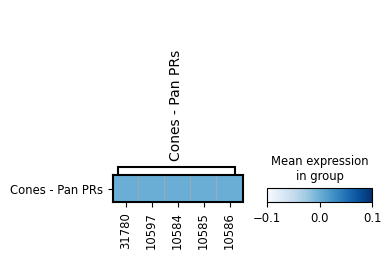

In [28]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, standard_scale='var', cmap='Blues',save='celltype_module')

In [29]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


df2 = pd.DataFrame(gene_adata_hvg.X,index=gene_adata_hvg.obs_names,columns=gene_adata_hvg.var_names)
#df2_t = df2.transpose()

# build network for each cluster
for key in mgs.keys():
    plt.clf()
    genesub = mgs[key]
    genesub =list(genesub)
    clust = df2.loc[genesub]
    print(key, genesub)
    G = nx.Graph()
    similarities = cosine_similarity(clust)
    genes = list(clust.index.values)
    similarities[similarities>0.9999]=0
    edges = []
    nz = list(zip(*similarities.nonzero()))
    for n in tqdm(nz):
        edges.append((genes[n[0]], genes[n[1]],{'weight':similarities[n[0],n[1]]}))
    G.add_nodes_from(genes)
    G.add_edges_from(edges)
    widths = nx.get_edge_attributes(G, 'weight')
    weightvalue = np.array(list(widths.values()))
    scaled_weightvalue = (weightvalue-weightvalue.min())/(weightvalue.max()-weightvalue.min())*3
    widsorted = sorted(widths.items(), key=lambda x: x[1], reverse=True)
    toppair = np.array(list(widths))[weightvalue.argsort()<3]
    pos = nx.spring_layout(G, k=0.4, iterations=15, seed=42)
    # draw network
    nx.draw_networkx_edges(G, pos,
                       edgelist = widths.keys(),
                       edge_color=list(widths.values()),
                       width=scaled_weightvalue,
                       edge_cmap=mpl.colormaps['cool'],
                       alpha=1)
    nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif")
    # edge weight labels
    edge_labels = {widsorted[i][0]: f'rank{i+1}' for i in range(5)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)
    # plot
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    filename = 'figures/cone_clust_' + str(key) +'_genemodule.pdf'
    plt.savefig(filename, bbox_inches='tight')
    plt.close()


4 ['A1CF', 'ABHD5', 'ACP4', 'ACSL4', 'ADAM23', 'ADAMTS20', 'ADCY6', 'ALDH4A1', 'AMH', 'ANKRD6', 'ANKS6', 'ANOS1', 'ANXA13', 'AP3D1', 'AP5M1', 'ARHGAP22', 'ARHGEF38', 'ASF1A', 'ATG12', 'ATP10D', 'ATP6V1C1', 'BAIAP2L1', 'BCAT2', 'BCDIN3D', 'BEGAIN', 'BET1', 'BMF', 'BMP5', 'BORCS7', 'C2orf72', 'C3orf14', 'CAPN2', 'CAPNS1', 'CASP7', 'CASS4', 'CBARP', 'CD99L2', 'CDC20', 'CDKL3', 'CEP78', 'CFAP44', 'CFAP58', 'CFAP92', 'CFAP97D1', 'CGNL1', 'CHST10', 'CLEC11A', 'CNIH3', 'CNOT8', 'COL13A1', 'COL4A1', 'COLEC11', 'CORIN', 'COX11', 'CRYL1', 'CSMD1', 'CSTF2', 'CUBN', 'DAGLA', 'DCBLD1', 'DCT', 'DDHD2', 'DDR2', 'DLGAP2', 'DLGAP5', 'DTX1', 'DYRK1B', 'DZIP1L', 'ECM2', 'EFHC2', 'EFHD2', 'ELOVL6', 'ELP4', 'EPHA4', 'EYA4', 'FAM171A1', 'FAM178B', 'FAM216A', 'FAM227A', 'FANCD2', 'FBN2', 'FBXO17', 'FHL2', 'FRS3', 'FUT1', 'GAD2', 'GALNT9', 'GALT', 'GBP1', 'GJC1', 'GSDME', 'GTF2H2C', 'HAP1', 'HES2', 'HES5', 'HHIP', 'HMCN1', 'HS3ST5', 'HSD17B3', 'HTR1E', 'IGDCC4', 'IGFBPL1', 'IGFN1', 'IL12RB2', 'IQCK', 'IQUB', 

100%|██████████| 60762/60762 [00:00<00:00, 154805.79it/s]


8 ['A2ML1', 'ABCG5', 'ABHD4', 'ADGRE5', 'AKAP10', 'ALG2', 'ALKBH3', 'ANAPC4', 'ANGPTL2', 'APEX2', 'ARHGEF2', 'ARSA', 'B4GALNT4', 'BAIAP3', 'BAMBI', 'BCAR1', 'BEND6', 'BOLA2B', 'BPIFB3', 'BPIFC', 'C11orf80', 'CABLES1', 'CADM4', 'CALML4', 'CASP9', 'CATSPER2', 'CCDC71', 'CCDC81', 'CD276', 'CD58', 'CENPU', 'CHEK2', 'CHRNB3', 'CKS1B', 'CMC1', 'COX7A1', 'CPT1A', 'CRYBG3', 'CTDP1', 'CTNS', 'CUL4A', 'CYB561D1', 'CYP46A1', 'DEPDC1B', 'DHX34', 'DNAAF1', 'DNAI1', 'DND1', 'DPP6', 'DPYSL5', 'DRC1', 'ELMOD1', 'EMILIN1', 'ENKD1', 'ENTPD1', 'EPHB4', 'EPS8L1', 'ERICH3', 'ERICH6', 'FADS6', 'FANCC', 'FBXW2', 'FBXW4', 'FKBP11', 'FKBP9', 'FOXN4', 'GABARAP', 'GALNS', 'GAP43', 'GBX1', 'GEMIN5', 'GLIPR2', 'GRB14', 'GSAP', 'GSTO2', 'GTF3C3', 'HHLA2', 'HKDC1', 'HMSD', 'HNF1A', 'HOATZ', 'HSD11B1L', 'HSD17B2', 'HTR4', 'ICOSLG', 'IER5L', 'IFFO2', 'INPPL1', 'ISG20L2', 'ITGB4', 'KCNH8', 'KCNJ6', 'KIF14', 'KIF19', 'KIFC1', 'KIFC2', 'LEFTY2', 'LGALS4', 'LRFN5', 'LY6G6D', 'LYPD4', 'LYSMD1', 'MAOB', 'MCUR1', 'MEIOB', 'M

100%|██████████| 41412/41412 [00:00<00:00, 112022.82it/s]


9 ['AAAS', 'ADAM15', 'AGTRAP', 'ALG12', 'ANKRD45', 'ARHGEF5', 'ARRDC4', 'ARSK', 'ATG16L2', 'ATIC', 'ATP11C', 'B3GALT2', 'B4GALT2', 'BLMH', 'BMP6', 'BRCA2', 'BRD3OS', 'BTBD19', 'BTN2A2', 'C11orf71', 'C18orf54', 'C1orf109', 'C4orf3', 'C4orf50', 'CACTIN', 'CALCOCO1', 'CD302', 'CDCP1', 'CDK2', 'CDNF', 'CEP152', 'CEP20', 'CERS2', 'CLK3', 'CLPP', 'CLPTM1L', 'CMTR2', 'CNOT3', 'CNPPD1', 'COMMD8', 'COMTD1', 'COQ9', 'CPVL', 'CSRP3', 'CTSO', 'CYP27A1', 'DCAF17', 'DDX19B', 'DGKA', 'DHX58', 'DIMT1', 'DMKN', 'DNAH8', 'DNAJC27', 'DVL1', 'EBI3', 'EFNA3', 'EGFL6', 'ELP6', 'ERAS', 'FAM102B', 'FAM174C', 'FAM200A', 'FAM50A', 'FBXL12', 'FERMT1', 'FGF7', 'FZD2', 'GAS2L1', 'GIMAP4', 'GNAT1', 'GPC2', 'GPRC5C', 'HACD4', 'HARS2', 'HAUS4', 'HPS3', 'HTR2C', 'IKZF1', 'IL33', 'INO80C', 'INPP1', 'IRAK1', 'IRAK3', 'ITGB1BP1', 'ITPKB', 'JMJD6', 'KEAP1', 'KIAA0408', 'KIAA1143', 'KSR1', 'LAMP5', 'LCN2', 'LIMD2', 'LIN9', 'LRP2BP', 'LYN', 'LYRM7', 'METAP1', 'MFSD1', 'MFSD5', 'MMS22L', 'MOB3A', 'MOV10', 'MPDU1', 'MTAP', 'M

100%|██████████| 39402/39402 [00:00<00:00, 743404.24it/s]


6 ['AARD', 'AASS', 'ABCA9', 'ABHD15', 'ACAP3', 'ALCAM', 'ALG8', 'ALOX15B', 'APC2', 'APEX1', 'ARHGEF1', 'ARID5B', 'ATAD5', 'ATP2A3', 'BAZ1A', 'BCAN', 'BCL2L11', 'BCL6', 'BPNT1', 'C17orf58', 'C1S', 'C4orf33', 'C4orf47', 'C5orf63', 'CASP8', 'CCDC28B', 'CEBPB', 'CENPF', 'CEP76', 'CFAP70', 'CFTR', 'CHMP7', 'CMTM6', 'CMTM7', 'CNKSR3', 'CNTNAP2', 'CNTNAP4', 'COL4A4', 'COX19', 'CPNE1', 'CRTAC1', 'CYP24A1', 'CYSTM1', 'DCDC2', 'DCXR', 'DENND2A', 'DEPDC7', 'DGKG', 'DSN1', 'DTWD1', 'EBP', 'EGFR', 'EPHB1', 'ERO1B', 'ESAM', 'FAM135B', 'FAM20A', 'FANCF', 'FASTKD2', 'FBLN5', 'FBXO4', 'FGFR1OP2', 'GABRG2', 'GATAD1', 'GGCX', 'GMEB1', 'GPANK1', 'GPC3', 'GPC6', 'GRIA2', 'GTF3A', 'HCN3', 'HGF', 'HID1', 'HMGCS2', 'HPR', 'HRK', 'IARS2', 'IGF1', 'IGFBP3', 'IL6R', 'IMPDH2', 'ING3', 'INSIG1', 'INSYN2A', 'INTS3', 'IQCH', 'ITPR2', 'JAKMIP2', 'KBTBD2', 'KCTD12', 'KHDRBS2', 'KIF11', 'KREMEN1', 'LARS2', 'LIX1L', 'LPL', 'LRCH4', 'MBLAC2', 'METTL23', 'MORN2', 'MRPS21', 'MRPS34', 'MTHFD1', 'MYC', 'MYRF', 'NAA40', 'NAA5

100%|██████████| 41820/41820 [00:00<00:00, 718260.97it/s]


2 ['ABCA13', 'ABCB8', 'ABCC2', 'ABHD8', 'ACADL', 'ACSM3', 'ADAM22', 'ADCK1', 'ADGRD2', 'AKAP1', 'ALDH2', 'ANXA4', 'ARFGAP3', 'ARHGAP21', 'ARHGAP27', 'ARHGEF17', 'ARID5A', 'ASNS', 'ASTN1', 'ATL1', 'ATP2B2', 'AURKB', 'B3GAT1', 'BCAS4', 'BCAT1', 'BRCA1', 'C11orf24', 'C15orf40', 'C16orf95', 'C2', 'C3orf49', 'C4B', 'C4orf19', 'C9orf72', 'CA5B', 'CACNG7', 'CALB1', 'CAPN6', 'CASKIN2', 'CAVIN4', 'CBX2', 'CCDC159', 'CCNG2', 'CD8A', 'CDC23', 'CDK19', 'CENPB', 'CFAP69', 'CHPF2', 'CLEC1A', 'CLSTN3', 'CNBD1', 'COG1', 'COL21A1', 'COL23A1', 'CPA5', 'CPSF1', 'CRTAP', 'CTSW', 'CYB561A3', 'DACT1', 'DAPP1', 'DAW1', 'DENND11', 'DHRS1', 'DMAC1', 'DNAH5', 'DNHD1', 'EAF1', 'ECE1', 'EDEM2', 'EEF1AKMT4', 'EMB', 'EMC8', 'ENG', 'ENTPD5', 'EPHA8', 'ERAP1', 'FAM102A', 'FAM167A', 'FAM229B', 'FAM83G', 'FBP2', 'FHL3', 'FLRT3', 'FLT3', 'FNDC7', 'FRRS1', 'GABRG3', 'GAS2', 'GCC1', 'GCNT7', 'GMPPA', 'GORASP1', 'GP1BB', 'GPATCH3', 'GPR137B', 'GPR63', 'GRIN2B', 'GRK1', 'GRM6', 'GRM7', 'GYG2', 'HAPLN1', 'HERC5', 'HERC6', 'H

100%|██████████| 82082/82082 [00:00<00:00, 172781.18it/s]


15 ['ABCA5', 'ADAM19', 'ADCY9', 'AFF2', 'ANGPT1', 'BCL7A', 'BEST3', 'BTG1', 'CCND3', 'CHGA', 'CLASRP', 'CLIC6', 'CNTNAP5', 'COL4A3', 'CREM', 'CYTH4', 'EEF2K', 'EFCAB12', 'ERCC4', 'FAM184A', 'FAT3', 'HRH2', 'HSPB11', 'INSR', 'LIN52', 'LRRC39', 'LRRC7', 'LRSAM1', 'MEGF11', 'NDUFC1', 'OGDHL', 'ORC2', 'PCBP1', 'PLCL1', 'PLEKHD1', 'PPP2R3A', 'PRDM6', 'PTGR1', 'QPRT', 'RASGRP3', 'RNF213', 'RPP30', 'RSAD1', 'SDK2', 'SFXN1', 'SH2D3A', 'SLC44A5', 'STK32A', 'STRA6', 'SUPT3H', 'TRIM44', 'ZBTB38', 'ZFP14', 'ZNF37A']


100%|██████████| 2862/2862 [00:00<00:00, 727609.29it/s]


7 ['ABCB9', 'ABCC3', 'ACHE', 'ADAMTS16', 'ADAMTSL1', 'ADAP1', 'AFAP1', 'AGBL2', 'AK8', 'AKAP14', 'ALPL', 'ANO1', 'ARG1', 'ARHGEF28', 'ARMC12', 'ASB4', 'ASIC5', 'ASXL3', 'ATP6V0C', 'BSCL2', 'C10orf105', 'C2orf66', 'C8orf76', 'CASP10', 'CCDC38', 'CCNB1', 'CES3', 'CFAP126', 'CFAP91', 'CFC1B', 'CLCN1', 'COL4A2', 'CPLANE2', 'CSF1', 'CXorf38', 'CYP7B1', 'DAO', 'DBNDD1', 'DCLK3', 'DIS3L', 'DMPK', 'DOCK11', 'DOP1B', 'DRD2', 'DUSP19', 'ECEL1', 'EDC4', 'EFHB', 'ELL', 'EME2', 'EMP1', 'EPHX3', 'ESS2', 'EXD1', 'F10', 'FAH', 'FAM110A', 'FAM174B', 'FAM185A', 'FAM205C', 'FBXO41', 'FER1L6', 'FGD1', 'FGFBP3', 'FHIP1B', 'FHL1', 'FLOT1', 'FOLR2', 'GABRR1', 'GFRA3', 'GLOD5', 'GMPPB', 'GSTA4', 'GTPBP3', 'H2AC16', 'HCST', 'HIVEP2', 'HK3', 'HTD2', 'HVCN1', 'IFITM5', 'IGSF9B', 'INPP4A', 'IQSEC2', 'ITPRIP', 'JOSD1', 'KANK2', 'KCTD18', 'KCTD2', 'KIF5A', 'KLF8', 'KRTCAP3', 'LDAF1', 'LLGL1', 'LMTK3', 'LRRC73', 'MANEA', 'METTL13', 'MGAM', 'MINAR2', 'MOGAT1', 'MOSPD2', 'MPZL3', 'MTMR12', 'MUC19', 'MUC5B', 'MYLK4', '

100%|██████████| 41412/41412 [00:00<00:00, 690038.88it/s]


1 ['ABCC10', 'ACAD9', 'ACTR8', 'ADCY10', 'AGA', 'AGXT2', 'AIRE', 'AK5', 'ALOX5', 'ALX3', 'AMER1', 'AMOT', 'ANKRD2', 'APBA2', 'ARHGAP36', 'ARHGAP8', 'ARHGEF26', 'AS3MT', 'ATAD3A', 'ATG10', 'ATP8B3', 'BAD', 'BAP1', 'BBOF1', 'BBS10', 'BCL11A', 'BHLHE40', 'BMP7', 'BRINP2', 'C11orf87', 'C2orf73', 'C4orf36', 'CACNA1S', 'CAP2', 'CATSPER1', 'CATSPERG', 'CCDC106', 'CCDC146', 'CCDC153', 'CCDC180', 'CCDC78', 'CCDC89', 'CDAN1', 'CDC25C', 'CDK15', 'CDO1', 'CDRT4', 'CEBPE', 'CELSR2', 'CENPN', 'CENPQ', 'CFAP221', 'CFAP300', 'CGREF1', 'CNRIP1', 'COLEC10', 'CPXM2', 'CRYZ', 'CTBP1', 'CYFIP1', 'DCLRE1A', 'DCLRE1B', 'DHCR7', 'DLEC1', 'DLX5', 'DMC1', 'DNASE1L2', 'DOCK6', 'DPF1', 'DRAXIN', 'DTX2', 'ECRG4', 'EDARADD', 'EGLN3', 'EHD2', 'EIF4EBP1', 'EXO5', 'FAM234A', 'FBXO31', 'FEN1', 'FERMT3', 'FGFR2', 'FHL5', 'FLNB', 'FOXP3', 'FOXRED2', 'FZD7', 'GCAT', 'GEMIN7', 'GHDC', 'GLI2', 'GLYCTK', 'GPR139', 'GPR180', 'GPR19', 'GPR87', 'GRM3', 'GTF2E1', 'GYS1', 'H2AC17', 'H2BC18', 'H2BC5', 'HAUS5', 'HBQ1', 'HDX', 'HS1B

100%|██████████| 85556/85556 [00:00<00:00, 157325.18it/s]


0 ['ABCC6', 'ACAA2', 'ACAD11', 'ACOX2', 'ACP6', 'ACRBP', 'ACSF3', 'ACSL5', 'ACSM5', 'ACVR2B', 'ADCY3', 'ADGRL4', 'AIDA', 'ALG5', 'ALKBH8', 'ANKAR', 'ANKRD49', 'ANKRD50', 'ANPEP', 'AOPEP', 'APOBEC3F', 'APOBEC3H', 'ARHGAP29', 'ARMC5', 'ASNSD1', 'ATAD2', 'ATG2A', 'ATL3', 'ATOH8', 'ATP4B', 'ATP8B2', 'BBS12', 'BGLAP', 'BTBD3', 'C12orf56', 'C19orf47', 'C19orf84', 'C1orf105', 'C1orf87', 'C22orf39', 'C3orf84', 'C9', 'CABP1', 'CACNA1E', 'CACNB4', 'CADPS2', 'CAPS2', 'CARHSP1', 'CCDC141', 'CCDC170', 'CCDC171', 'CCDC51', 'CCNA2', 'CCNB3', 'CCSAP', 'CD24', 'CD82', 'CDH6', 'CEACAM21', 'CELF5', 'CEMIP', 'CEND1', 'CEP250', 'CFB', 'CHIC1', 'CHKA', 'CHRM2', 'CIAO3', 'CIT', 'CKMT2', 'CLEC1B', 'CLHC1', 'CMYA5', 'CNMD', 'COL14A1', 'COPS7B', 'CRABP2', 'CRACR2A', 'CRYBB1', 'CTSA', 'CYB5D2', 'CYP2U1', 'DAB2', 'DERA', 'DGCR8', 'DIO2', 'DISP3', 'DKK1', 'DNAAF11', 'DNAJB9', 'DNPH1', 'DOLK', 'DPEP2', 'DPP3', 'DSG2', 'DUOXA1', 'ECT2', 'EDEM1', 'EIF5A2', 'ENOSF1', 'ENPP3', 'EPB41L4B', 'ESRP2', 'ETV1', 'EVC2', 'EXOS

100%|██████████| 90300/90300 [00:00<00:00, 163555.58it/s]


14 ['ABCC9', 'ADAMTS14', 'ADAMTS15', 'AIF1L', 'ANG', 'AXL', 'BST2', 'CAPS', 'CATIP', 'CCDC8', 'CFAP45', 'CLDN1', 'COL4A5', 'CPSF4L', 'CRYBB3', 'CSRP1', 'DNAJB13', 'DNASE1L1', 'EFNA1', 'F2R', 'FAM166B', 'FBLN7', 'FOLH1', 'FOSB', 'FOXJ1', 'FRZB', 'GARIN1B', 'GM2A', 'GRAMD2B', 'HEPACAM', 'HEY2', 'ID3', 'JPH2', 'KCNG1', 'KLF5', 'KLHL14', 'LHX9', 'LIPM', 'LKAAEAR1', 'LRTM1', 'MAL2', 'MDFIC', 'MET', 'MINAR1', 'MMP25', 'MOXD1', 'MRC2', 'NECAB3', 'NID2', 'NOTCH3', 'PDGFRL', 'PID1', 'PRR7', 'PTGER4', 'RBPMS', 'RGCC', 'RRAS', 'RTP1', 'SLC16A2', 'SLC2A9', 'SLC7A2', 'SNED1', 'SOX8', 'SPTLC3', 'SQOR', 'SSPN', 'THBD', 'TIMP4', 'TMEM221', 'TMEM40', 'TMEM52', 'TRABD2B', 'ZBBX']


100%|██████████| 5256/5256 [00:00<00:00, 630982.36it/s]


5 ['ABCD1', 'ABTB1', 'ACADS', 'ACOT12', 'ADAP2', 'ADHFE1', 'ADPRH', 'AGBL5', 'AGPAT4', 'ANKRD37', 'APTX', 'ARHGAP28', 'ARMCX4', 'ASIC1', 'B4GALT3', 'B4GALT4', 'B4GALT5', 'BAHD1', 'BLM', 'C19orf81', 'C21orf62', 'CACNG1', 'CAMK1', 'CAPN15', 'CAT', 'CATSPERB', 'CCDC175', 'CCDC61', 'CELSR1', 'CEP44', 'CFAP251', 'CFAP276', 'CHST8', 'CMTM4', 'CNN1', 'CNTNAP3C', 'COBL', 'COL28A1', 'COX10', 'CPLX2', 'CSAD', 'CSRNP1', 'CTXN1', 'CUX2', 'CYB5RL', 'CYBC1', 'DEFB103B', 'DEUP1', 'DHX35', 'DNAH2', 'DNAH3', 'DNAI4', 'DPH2', 'DPYSL4', 'EDA', 'EFCAB10', 'EFCAB11', 'EFCAB6', 'EIF4E3', 'ELMOD3', 'ENO4', 'ERBB2', 'ESR2', 'FAAP100', 'FBF1', 'FGF12', 'FGF14', 'FNDC1', 'FOXN2', 'FRRS1L', 'GALC', 'GALNTL5', 'GALR2', 'GIMD1', 'GLDN', 'GPC4', 'GPR39', 'GRIN2A', 'GRK2', 'GRM8', 'GXYLT1', 'H2AC13', 'HCFC1R1', 'HEMK1', 'HMG20B', 'HPCAL4', 'HPD', 'HSCB', 'HSPB8', 'HYLS1', 'IDS', 'IFT27', 'IFT52', 'IQCD', 'KCNH5', 'KLB', 'LDB2', 'LHX6', 'LMAN1L', 'LRGUK', 'LRRC4', 'LTBP1', 'LZTR1', 'LZTS1', 'MAP2K6', 'MAP3K15', 'MAST

100%|██████████| 46010/46010 [00:00<00:00, 675066.56it/s]


10 ['ABCD2', 'ACAD10', 'ADGRF5', 'AMIGO2', 'ANXA11', 'ARHGEF19', 'ARSD', 'ATP6V1G3', 'B3GNTL1', 'BAG3', 'BEX5', 'BICRA', 'BMP2', 'C19orf54', 'CAPN9', 'CCDC103', 'CCDC122', 'CD207', 'CD5L', 'CD80', 'CDH4', 'CDR2L', 'CFAP52', 'CHST7', 'CMC4', 'CMKLR2', 'CNTF', 'CNTN3', 'COPZ2', 'CPEB2', 'CPQ', 'CREB3L1', 'CRIP3', 'CWH43', 'CYB5R1', 'CYSLTR1', 'DENND3', 'DHRS3', 'DNAI3', 'DOCK10', 'DYNC1I1', 'EARS2', 'ELAPOR2', 'ENO3', 'EPHX1', 'FAM161B', 'FAM53A', 'FIZ1', 'FKBP14', 'FOSL1', 'FSTL4', 'GAB2', 'GABRB2', 'GALR3', 'GARIN2', 'GFER', 'GFPT2', 'GJC2', 'GPR108', 'GPR156', 'GREB1L', 'GRHL1', 'GRPR', 'GTPBP2', 'HDDC3', 'HIPK4', 'HSPG2', 'IFIT5', 'IFRD2', 'IMPACT', 'IRAG1', 'IRF6', 'KCNMA1', 'KCTD6', 'LENG9', 'LMF2', 'LMNTD2', 'LRRC45', 'LY6H', 'LY6L', 'MAPK7', 'MBOAT1', 'MCTP1', 'METTL22', 'MFSD2A', 'MIIP', 'MON1A', 'MSANTD2', 'MTHFS', 'MXD3', 'N4BP2L1', 'NEIL2', 'NHSL1', 'NSUN5', 'NT5M', 'NTRK2', 'OPRM1', 'ORM2', 'PANX1', 'PDGFD', 'PECAM1', 'PGM2', 'PHETA1', 'PIGBOS1', 'PLA2G6', 'PLEKHA4', 'PLEKHG

100%|██████████| 32580/32580 [00:00<00:00, 671514.06it/s]


16 ['ABHD2', 'AKT1S1', 'ARVCF', 'BTBD1', 'CAMK1G', 'CCDC117', 'CLDN34', 'ELOVL7', 'FAM20B', 'FKTN', 'GPC1', 'HYAL3', 'IFTAP', 'IRAK2', 'KIAA0513', 'KIF6', 'KLHDC3', 'LRP5', 'LRRN3', 'MAPK8IP1', 'MCM8', 'METTL21C', 'MOSPD3', 'NLE1', 'PACC1', 'PARVA', 'PLEKHH2', 'PMVK', 'RPUSD4', 'SFI1', 'SMIM29', 'STRN4', 'SUPV3L1', 'TAF4', 'TFE3', 'TK2', 'TMEM109', 'TRMT10B', 'WIPF2', 'ZFYVE1', 'ZNF239']


100%|██████████| 1640/1640 [00:00<00:00, 597884.27it/s]


11 ['ABITRAM', 'ADGRL1', 'ALKBH2', 'ALOX5AP', 'ANAPC5', 'ARHGEF39', 'ARL4D', 'ASTE1', 'BACE2', 'BET1L', 'C2orf74', 'C6orf89', 'CA11', 'CASP2', 'CCDC60', 'CD99', 'CDC42SE1', 'CDH1', 'CDR2', 'CLDN19', 'CNP', 'COA4', 'COL22A1', 'CREB3L2', 'CTU2', 'DAGLB', 'DDX41', 'DLX6', 'DNA2', 'DNAJC30', 'DNALI1', 'DZIP3', 'E2F6', 'ECH1', 'EID2', 'ERICH2', 'EVI2A', 'EXOSC7', 'FAM13C', 'FAM217B', 'FES', 'FLVCR1', 'FLYWCH1', 'GNPAT', 'GRWD1', 'GUCD1', 'HEBP2', 'HSD17B10', 'IFT22', 'IGSF6', 'IQCB1', 'ISCA2', 'ITGA10', 'ITPR3', 'JAML', 'KBTBD3', 'KCNC4', 'KIF1C', 'KIF2C', 'KIF9', 'KLF15', 'KLHDC9', 'KLHL36', 'KLHL9', 'KRT19', 'LIFR', 'LRRC56', 'LTBP3', 'LTBR', 'LTF', 'LYRM1', 'MAD2L1', 'MARS2', 'MCPH1', 'MECP2', 'MEP1B', 'METTL18', 'METTL24', 'MICALL2', 'MMAB', 'MON1B', 'MPV17', 'MRPS17', 'MTPAP', 'MYBPC1', 'MYO7B', 'NHLRC3', 'NME6', 'NOM1', 'NOX1', 'NPPC', 'OCIAD2', 'P3H3', 'PCED1A', 'PCK2', 'PDPR', 'PHOSPHO2', 'PIDD1', 'PIN4', 'PLPP5', 'POLD4', 'POR', 'PPM1K', 'PRRC1', 'PRRT1', 'PTGR2', 'PTTG2', 'RAD51C'

100%|██████████| 23562/23562 [00:00<00:00, 670972.45it/s]


3 ['ACAP1', 'ACOT9', 'ADAM12', 'ADAMTS10', 'ADARB2', 'ADCY8', 'ADGRL3', 'AGBL1', 'AGT', 'AKT2', 'ALDH1L2', 'ALG3', 'AMZ2', 'ANO4', 'APH1B', 'APOBEC2', 'ARAP1', 'ARHGAP15', 'ARMCX2', 'ATP13A1', 'ATP8B4', 'BATF3', 'BBS2', 'BLVRB', 'BRD8', 'BRIP1', 'BYSL', 'C2orf68', 'CACNG8', 'CBX7', 'CCDC158', 'CCDC167', 'CCDC24', 'CCDC28A', 'CCDC57', 'CCDC92', 'CCL28', 'CD38', 'CDH7', 'CDH9', 'CDYL', 'CEP41', 'CEP43', 'CERS1', 'CFAP410', 'CFLAR', 'CNTN2', 'COG8', 'COL24A1', 'CPEB1', 'CPED1', 'CRTC2', 'CSF2RB', 'CTH', 'CTNNA2', 'CXCL12', 'DCX', 'DDC', 'DGAT2', 'DGKH', 'DLAT', 'DRC3', 'DSC2', 'DUS3L', 'EDNRB', 'EHD1', 'EIF2D', 'EIF4EBP3', 'ELOVL5', 'ELP5', 'EMID1', 'ENOX2', 'ENPP1', 'ENPP2', 'ENPP5', 'ENPP6', 'ERICH1', 'FAM110C', 'FAM228A', 'FAM228B', 'FAM81B', 'FBN3', 'FBP1', 'FBXO25', 'FCAMR', 'FOCAD', 'FOXP2', 'FREM2', 'FRMPD4', 'FUNDC2', 'GABPB2', 'GABRB1', 'GALP', 'GAMT', 'GINS1', 'GINS2', 'GNG7', 'GPC5', 'GPLD1', 'GPRASP1', 'GPRC5B', 'GPX3', 'GRAMD4', 'GRIA4', 'GSDMB', 'HARBI1', 'HIP1R', 'HK2', 'HS

100%|██████████| 71556/71556 [00:00<00:00, 121641.83it/s]


12 ['ACP2', 'ACTR5', 'ADAMTS7', 'ADAT1', 'ADGRA2', 'AFMID', 'ANKRD34B', 'AP4B1', 'AP5Z1', 'ARHGAP19', 'ATXN7L3', 'C12orf43', 'C19orf85', 'C20orf204', 'C9orf24', 'CALR3', 'CBS', 'CCDC134', 'CCN1', 'CCNB2', 'CCNQ', 'CDC45', 'CENPH', 'CHD1L', 'CHKB', 'CLSPN', 'CNGA1', 'CNPY4', 'COLGALT1', 'CRAMP1', 'CRAT', 'DGKZ', 'DIRAS3', 'DLG3', 'DPH6', 'DUSP6', 'DZIP1', 'EGLN2', 'ERFL', 'ETS1', 'EXPH5', 'FAHD1', 'FAM221B', 'FBXO15', 'FITM1', 'FKRP', 'FTCDNL1', 'FYB1', 'G6PC3', 'GAA', 'GADL1', 'GARS1', 'GCDH', 'GIPC2', 'GNRH1', 'GOLT1B', 'GRIN2D', 'GTF2H4', 'GVQW3', 'HSD17B11', 'JMJD7', 'KCTD14', 'KDM1B', 'LIAS', 'LIMA1', 'LIMD1', 'LRRC2', 'MESP1', 'MILR1', 'MISP3', 'MLST8', 'MMAA', 'MTMR14', 'NCKIPSD', 'NSMAF', 'NUP133', 'NXT2', 'PALM2AKAP2', 'PCNX3', 'PHC1', 'PLEK2', 'PPP1R3D', 'PRTFDC1', 'PSME2', 'RAB8A', 'RABL3', 'RAD1', 'RBM7', 'RIPK4', 'SERTAD1', 'SLC12A9', 'SLC25A27', 'SLC7A7', 'SPATC1', 'ST6GALNAC4', 'STBD1', 'STK10', 'SYCP3', 'SYK', 'TAMALIN', 'TCP11L1', 'TDP1', 'TFR2', 'TLCD2', 'TMEM169', 'TM

100%|██████████| 15500/15500 [00:00<00:00, 654535.23it/s]


13 ['ADAMTSL3', 'ANGEL1', 'ARHGAP44', 'ARHGEF33', 'ARHGEF9', 'ATG4D', 'BCO1', 'BICDL2', 'CACNA1A', 'CACNA1C', 'CD151', 'CDK16', 'CFAP43', 'CNNM4', 'COQ8A', 'CTDSPL', 'CUL7', 'DNAI2', 'DNAJB4', 'DPP9', 'DSCAM', 'DUSP3', 'DVL3', 'FSD1', 'IL1RAPL2', 'KIF16B', 'LHX1', 'LYPLAL1', 'MAP3K14', 'MAPRE2', 'MARK4', 'MESP2', 'MPP3', 'MVB12B', 'MYT1L', 'NAAA', 'NTSR2', 'NUDT2', 'PAK4', 'PDE1B', 'POMT1', 'PPP1CA', 'PRLR', 'RAB36', 'RBMS2', 'RETREG2', 'SCGN', 'SCYL3', 'SHC1', 'SIDT1', 'SLC22A4', 'SLC26A6', 'SLC41A1', 'SMARCAL1', 'SMTN', 'SP2', 'SPOP', 'STX1A', 'SUMF1', 'SYNPO2', 'TDRP', 'TMEM117', 'TMEM175', 'TMOD2', 'TMUB2', 'TPH2', 'TRAPPC14', 'TSC2', 'UEVLD', 'UNC5A', 'USP42', 'WFDC3', 'XKR5', 'ZFP28']


100%|██████████| 5402/5402 [00:00<00:00, 638279.06it/s]


## Use emb for pySCENIC

In [32]:
#cell_geneemb = np.load('./data/cd8t_b_mono_geneemb_01B-resolution_singlecell_gene_embedding_f1_resolution.npy')
cell_geneemb

array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-6.92784712e-02,  4.02336717e-02,  6.18375018e-02, ...,
          5.92425205e-02, -4.71354797e-02, -7.37854242e-02],
        [-2.90654786e-02,  1.18232556e-01, -4.62347120e-02, ...,
          2.64367014e-01, -8.53215754e

In [38]:
selected_gene = adata.X.sum(0)>0
geneemb_merge = cell_geneemb[:,selected_gene,0] #.mean(0)
geneemb_merge.shape

(516, 6419)

In [39]:
TF = pd.read_csv('./data/hs_hgnc_tfs.txt',header=None).values.T[0]
sgene = np.array(gene_list)[selected_gene]
fltTF = [x for x in TF if x in sgene]
len(fltTF)

614

In [43]:
len(sgene)
geneemb_merge_t = geneemb_merge.transpose()
geneemb_merge_t.shape

(6419, 516)

In [50]:
fltgeneembdf = pd.DataFrame(geneemb_merge_t,index=sgene)
fltgeneembdf = fltgeneembdf.dropna(axis=1)
fltgeneembdf

,1,2,4,5,6,10,12,13,15,17,...,501,502,503,507,508,509,510,511,512,514
A3GALT2,-0.058932,-0.051394,-0.049141,-0.059104,-0.045418,-0.050561,-0.052747,-0.051919,-0.041041,-0.035713,...,-0.057861,-0.050554,-0.057745,-0.050582,-0.042732,-0.055948,-0.046956,-0.042486,-0.054351,-0.044926
AACS,0.122950,-0.054240,-0.088393,-0.041769,-0.068136,-0.063906,-0.082696,-0.063705,-0.053866,-0.056097,...,-0.069656,-0.069894,-0.052723,-0.055513,-0.068969,-0.069731,-0.059906,-0.050935,-0.047182,-0.066402
AADAT,-0.163353,-0.114843,-0.145136,-0.115454,-0.095814,-0.109591,-0.127227,-0.089896,-0.107917,-0.074901,...,-0.130419,-0.112242,-0.100636,-0.095081,-0.100519,-0.126044,-0.106960,-0.097430,-0.098456,-0.091067
AAGAB,-0.037842,-0.125161,-0.077449,-0.086551,-0.092218,-0.122875,-0.114673,-0.144358,-0.148219,-0.077586,...,-0.102200,-0.109266,-0.117144,-0.220076,0.068442,-0.141625,-0.003802,-0.112916,-0.097316,-0.162744
AAK1,-0.092223,-0.223381,-0.365524,-0.172274,-0.356369,-0.459582,-0.602866,-0.198902,-0.263236,-0.159947,...,-0.183493,-0.447928,-0.169585,-0.248790,-0.497516,-0.164097,-0.479005,-0.314824,-0.203545,-0.134468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.095771,-0.031870,-0.034394,-0.046409,-0.025727,-0.029313,0.092974,-0.026194,-0.079246,0.087059,...,-0.037064,-0.030215,-0.038290,0.017885,-0.010192,-0.011999,-0.038379,-0.043664,-0.050374,-0.013932
ZYG11A,-0.003656,-0.037865,-0.016913,-0.039433,-0.047951,-0.048472,-0.038200,-0.044753,-0.074609,-0.048907,...,-0.043120,-0.036517,-0.057114,-0.026436,-0.011426,-0.056884,-0.055758,-0.054710,-0.043231,-0.058854
ZYG11B,-0.008362,-0.192290,-0.084677,-0.053336,-0.007879,0.023748,-0.047995,-0.052295,-0.162665,0.151628,...,-0.183092,0.059544,0.006961,-0.216699,-0.115350,-0.099875,-0.150089,-0.109590,-0.070168,-0.032683
ZZEF1,0.035095,-0.018254,0.009669,0.042112,-0.005923,0.018915,0.184730,0.038855,0.068378,-0.138831,...,0.116323,0.208484,-0.014826,0.055695,0.030977,0.007832,-0.003493,0.001023,-0.019596,0.008283


In [51]:
coexplist=[]
# get cosign similarities for TFs
for tf in tqdm(fltTF):
    tmpsim = cosine_similarity(fltgeneembdf.loc[fltTF[0],:].values.reshape(1,-1),fltgeneembdf)
    tmpsim[tmpsim>0.9999]=0
    tmpsimdf = pd.DataFrame(tmpsim,columns=sgene,index=['simi']).T
    tmpsimdf = tmpsimdf.sort_values('simi',ascending=False)
    for idx in range(1000):
        coexplist.append([tf,tmpsimdf.index[idx],tmpsimdf.iloc[idx,0]*100])

100%|██████████| 614/614 [01:13<00:00,  8.32it/s]


In [52]:
grndf = pd.DataFrame(coexplist,columns=['TF','target','importance'])

In [53]:
grndf.to_csv('scf_grn_1000.tsv',index=False,sep='\t')

In [54]:
grndf.head()

,TF,target,importance
0,ZNF8,CDH15,84.269649
1,ZNF8,SLC5A4,83.318973
2,ZNF8,ZNF45,83.248663
3,ZNF8,MAP4K2,83.005190
4,ZNF8,SKA3,82.514042


feed into pyscenic

#bin/bash

docker run -it --rm \
    -v /nfs_beijing/:/nfs_beijing/ \
    aertslab/pyscenic:0.12.1 pyscenic ctx \
        ./geneemb/scf_grn_1000.tsv \
        ./geneemb/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
        --annotations_fname ./geneemb/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
        --expression_mtx_fname ./geneemb/data/zheng_subset_cd8t_b_mono.tsv \
        --mode "custom_multiprocessing" \
        --output ./geneemb/regulons_1000.csv \
        --num_workers 40
        
docker run -it --rm \
    -v /nfs_beijing/:/nfs_beijing/ \
    aertslab/pyscenic:0.12.1 pyscenic aucell \
        ./geneemb/data/zheng_subset_cd8t_b_mono.tsv \
        ./geneemb/regulons_1000.csv \
        -o ./geneemb/auc_mtx_1000.csv \
        --num_workers 6

In [ ]:
# from another notebook for post-analysis
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
from pyscenic.binarization import binarize

In [ ]:
auc_mtx = pd.read_csv('./auc_mtx_1000.csv',index_col=0)

In [ ]:
cellanno = pd.DataFrame(['CD8+ Cytotoxic T']*100+['CD19+ B']*100+['CD14+ Monocyte']*100,columns=['anno'])

In [ ]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellanno['anno'] )
rss_cellType.to_csv('RSS.csv')
rss_cellType

In [ ]:
from adjustText import adjust_text
cats = sorted(list(set(cellanno['anno'])))

fig = plt.figure(figsize=(15, 5))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=3, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('RSS.pdf',bbox_inches='tight')